In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error, r2_score
import time

df1 = pd.read_csv("movies.csv")
df2 = pd.read_csv("TMDB_IMDB_Movies_Dataset.csv")

print("Dataset 1 shape:", df1.shape)
print("Dataset 2 shape:", df2.shape)

features2 = ["popularity", "vote_count", "release_date", "revenue",
             "runtime", "adult", "original_language", "genres"]

target2 = "vote_average"

X2 = df2[features2].copy()
y2 = df2[target2].copy()

Dataset 1 shape: (8560, 6)
Dataset 2 shape: (433937, 13)


In [5]:
def preprocess_features(X):
    X = X.copy()

    if "release_date" in X.columns:
        X["release_year"] = pd.to_datetime(X["release_date"], errors="coerce").dt.year
        X["release_year"].fillna(X["release_year"].median(), inplace=True)
        X.drop(columns=["release_date"], inplace=True)

    if "adult" in X.columns:
        X["adult"] = X["adult"].astype(int)

    if "genres" in X.columns:
        X["genres"] = X["genres"].fillna("Unknown")
        X["genres"] = X["genres"].apply(
            lambda x: x.split(",")[0].strip() if isinstance(x, str) else "Unknown"
        )

    for col in ["genres", "original_language"]:
        if col in X.columns:
            top = X[col].value_counts().index[:10]
            X[col] = X[col].apply(lambda v: v if v in top else "Other")

    categorical_cols = [c for c in ["genres", "original_language", "adult"] if c in X.columns]
    numeric_cols = [c for c in X.columns if c not in categorical_cols]

    preprocessor = ColumnTransformer([
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("scale", StandardScaler(), numeric_cols)
    ])

    return preprocessor.fit_transform(X)

X2_processed = preprocess_features(X2)
print("Processed Dataset 2 shape:", X2_processed.shape)

C:\Users\vipra\AppData\Local\Temp\ipykernel_15804\3117933653.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["release_year"].fillna(X["release_year"].median(), inplace=True)


Processed Dataset 2 shape: (433937, 29)



Training linear_fast ...
linear_fast | MSE: 11.4723 | R²: -0.1613

Training svr_rbf ...


c:\Users\vipra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


svr_rbf | MSE: 9.7379 | R²: 0.0143

Total training time: 337.73 seconds


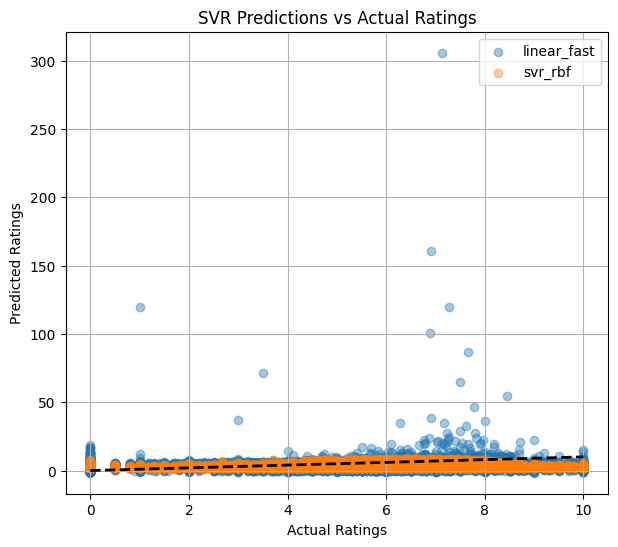

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X2_processed, y2, test_size=0.2, random_state=42
)

X_train_scaled = X_train
X_test_scaled = X_test

C_list = [0.1, 1, 10]
gamma_list = ['scale', 'auto']
epsilon_list = [0.1, 0.01]

models = {
    "linear_fast": LinearSVR(C=2.0, max_iter=10000),
    "svr_rbf": SVR(kernel="rbf", C=10, epsilon=0.2, gamma="scale", max_iter=1500)
}

predictions = {}
start_time = time.time()

for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    predictions[name] = preds

    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} | MSE: {mse:.4f} | R²: {r2:.4f}")

total_time = time.time() - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

plt.figure(figsize=(7,6))
for name, preds in predictions.items():
    plt.scatter(y_test, preds, alpha=0.4, label=name)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("SVR Predictions vs Actual Ratings")
plt.legend()
plt.grid(True)
plt.show()